<a href="https://colab.research.google.com/github/AlessLG/practicas_curvas-de-rotacion/blob/main/ajustes_curvas_rotacion_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import os

# G = 4.3e-3 # pc • (km/s)² / M_⊙
G = 4.3e-6 # kpc • (km/s)² / M_⊙

descargar_figuras = False

def v_Hernquist(r, M, a):
    return np.sqrt(G*M*r/(a+r)**2)

# def v_plummer(r, M, a):
#     return np.sqrt(G*M/(r*(1+a**2/r**2)**(3/2)))

def v_disk_plummer_cut(r, M_d, b_d, l_cut):
    # Modelo base de Plummer
    denom = (r**2 + b_d**2)**(1.5)
    v_sq = (G * M_d * r**2) / denom
    
    # Aplicar corte: v = 0 si r >= l_cut
    v_model = np.sqrt(np.maximum(v_sq, 0))
    return np.where(r >= l_cut, 0.0, v_model)

# def v_nfw(r, A, r_s):
#     return np.sqrt((4*np.pi*G*A)*((1/r)*np.log(1+r/r_s)-1/(r_s+r)))

def v_nfw(r, A, r_s):
    r_safe = np.maximum(r, 1e-10) 
    r_s_safe = np.maximum(r_s, 1e-10) 
    term = (4 * np.pi * G * A) * ((1/r_safe) * np.log(1 + r_safe/r_s_safe) - 1/(r_s_safe + r_safe))
    term = np.maximum(term, 0)
    return np.sqrt(term)

def v_sol_reparam(r, rho_c, a):
    B = rho_c * (a**16)
    return v_sol(r, B, a)

def v_sol(r, B, a):
    poly_part = (
        -0.177069 * a**13 * r
        + 0.225911 * a**11 * r**3
        + 0.039069 * a**9 * r**5
        + 0.0039039 * a**7 * r**7
        + 0.000229089 * a**5 * r**9
        + 7.36645e-6 * a**3 * r**11
        + 1.00552e-7 * a * r**13
    )
    arctan_poly_part = (
        0.586978 * a**14
        + 0.373905 * a**12 * r**2
        + 0.102076 * a**10 * r**4
        + 0.0154815 * a**8 * r**6
        + 0.00140882 * a**6 * r**8
        + 7.69216e-5 * a**4 * r**10
        + 2.33329e-6 * a**2 * r**12
        + 3.03327e-8 * r**14
    )
    arctan_term = arctan_poly_part * np.arctan(0.301662 * r / a)
    numerator_content = B * G * (poly_part + arctan_term)
    denominator = a**13 * r * (a**2 + 0.091 * r**2)**7
    term_inside_sqrt = np.maximum(0, (4 * np.pi * numerator_content) / denominator)
    velocity = np.sqrt(term_inside_sqrt)
    return velocity

def v_disk_miyamoto(r, M_d, a_d, b_d):
    # (R^2 + (a+b)^2)^(3/2)
    denom = (r**2 + (a_d + b_d)**2)**(1.5)
    v_sq = (G * M_d * r**2) / denom
    return np.sqrt(v_sq)

# def v_total_model(r, params, halo_func):
#     # params espera: [p1_halo, p2_halo, M_disk, a_disk, b_disk]
#     p_halo = params[0:2]      # Primeros 2 son del halo
#     p_disk = params[2:]       # Los siguientes 3 son del disco (M, a, b)
#     v_h = halo_func(r, *p_halo)
#     v_d = v_disk_miyamoto(r, *p_disk)
#     return np.sqrt(v_h**2 + v_d**2)

def v_total_model(r, params, halo_func, l_cut):
    """
    Calcula la velocidad total sumando en cuadratura el Halo y el Disco/Bulbo.
    params espera 4 valores: [p1_halo, p2_halo, M_disk, b_disk]
    """
    p_halo = params[0:2]      # [A, rs] para NFW
    p_disk = params[2:]       # [M, b] para Disco (a=0)
    
    v_h = halo_func(r, *p_halo)
    v_d = v_disk_plummer_cut(r, p_disk[0], p_disk[1], l_cut)
    
    return np.sqrt(v_h**2 + v_d**2)

In [9]:

def fit_and_plot_rotation_curve(file_path, show_plot=False, save_plot_path=None):
    # 1. Cargar datos
    try:
        data = np.genfromtxt(file_path, delimiter='\t')
        r_data, v_data, err_data = data[:, 0], data[:, 1], data[:, 2]
    except (IOError, IndexError) as e:
        print(f"Error al leer {file_path}: {e}")
        return None

    # 2. Configuración (Solo NFW + Disco simplificado)
    # x0 = [A_halo, rs_halo, M_disk, b_disk]
    # initial_guess = [1e7, 20.0,  5e9, 1.0] 
    initial_guess = [8.7e10, 66,  5e9, 1.0] 

    model_config = {
        "NFW + Disk": {
            "func": v_nfw, 
            "x0": initial_guess, 
            "labels": ["A (Halo)", "rs (Halo)", "M (Disco)", "b (Disco)"]
        },
    }
    
    resultados = {}

    Radio_corte = r_data.max() / 3

    def residuals(params, halo_func, r, v_obs, v_err):
        # Pasamos CUT_RADIUS a la función total
        v_teorica = v_total_model(r, params, halo_func, l_cut=Radio_corte)
        if not np.all(np.isfinite(v_teorica)):
             return np.ones_like(v_obs) * 1e10
        return (v_teorica - v_obs) / v_err

    # def residuals(params, halo_func, r, v_obs, v_err):
    #     v_teorica = v_total_model(r, params, halo_func)
    #     return (v_teorica - v_obs) / v_err

    # 3. Ajuste
    for name, config in model_config.items():
        # NFW, NFW; Plummer, Plummer.
        bounds_min = [1e4, 0.1, 1e6, 0.1] 
        bounds_max = [np.inf, 500.0, np.inf, 10.0]
        
        res = least_squares(
            residuals, 
            config["x0"], 
            args=(config["func"], r_data, v_data, err_data), 
            bounds=(bounds_min, bounds_max)
        )
        
        params = res.x
        # Cálculo de errores
        try:
            cov = np.linalg.inv(res.jac.T @ res.jac)
            errors = np.sqrt(np.diag(cov))
        except:
            cov = None
            errors = np.full_like(params, np.inf)
            
        dof = len(v_data) - len(params)
        chi2_red = np.sum(res.fun**2) / dof if dof > 0 else np.inf
        
        resultados[name] = {
            "params": params, 
            "errors": errors, 
            "chi2_red": chi2_red,
            "cov_matrix": cov,
            "func": config["func"]
        }

    # 4. Reporte
    galaxy_name = os.path.basename(file_path).split('_')[0]
    print(f"\n--- Resultados: {galaxy_name} (NFW + Disco Simp.) ---")
    
    for name, res in resultados.items():
        p = res['params']
        e = res['errors']
        lbl = model_config[name]["labels"]
        
        print(f"Modelo {name} (χ²_red = {res['chi2_red']:.3f})")
        print(f"  {lbl[0]:<10}: {p[0]:.2e} ± {e[0]:.1e}")
        print(f"  {lbl[1]:<10}: {p[1]:.2f} ± {e[1]:.2f} kpc")
        print(f"  {lbl[2]:<10}: {p[2]:.2e} ± {e[2]:.1e} M⊙")
        print(f"  {lbl[3]:<10}: {p[3]:.2f} ± {e[3]:.2f} kpc")
        print("-" * 45)

    # 5. Gráfica
    if not (show_plot or save_plot_path):
        return resultados

    d_plot = np.linspace(0.1, r_data.max(), 200)
    plt.figure(figsize=(6, 4))
    
    # Datos
    plt.errorbar(r_data, v_data, yerr=err_data, fmt='o', color='black', label='Datos SPARC', capsize=4, markersize=5)

    # Curvas de los modelos
    name = "NFW + Disk"
    res = resultados[name]
    p = res['params']
    
    # 1. Total
    # v_tot = v_total_model(d_plot, p, res['func'])
    # plt.plot(d_plot, v_tot, 'r-', lw=2, label=f'Total (χ²={res["chi2_red"]:.2f})')
    
    v_tot = v_total_model(d_plot, p, res['func'], l_cut=Radio_corte)
    plt.plot(d_plot, v_tot, 'r-', lw=2, label=f'Total (χ²={res["chi2_red"]:.2f})')

    # 2. Componentes Individuales
    # v_halo = res['func'](d_plot, p[0], p[1])
    # v_disk = v_plummer(d_plot, p[2], p[3])
    v_halo = res['func'](d_plot, p[0], p[1])
    v_disk = v_disk_plummer_cut(d_plot, p[2], p[3], l_cut=Radio_corte   )

    plt.plot(d_plot, v_halo, 'b--', label='Halo (NFW)')
    plt.plot(d_plot, v_disk, 'g:', label='Disco (Plummer)')

    plt.xlabel('Radio (kpc)')
    plt.ylabel('Velocidad (km/s)')
    plt.title(f'Ajuste de Curva de Rotación para {galaxy_name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    if save_plot_path:
        plt.savefig(f"{galaxy_name}_fit_total.png", bbox_inches='tight')
    
    if show_plot:
        plt.show()
    plt.close()

    return resultados


--- Resultados: F563-1 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 0.936)
  A (Halo)  : 5.99e+10 ± 7.5e+10
  rs (Halo) : 36.00 ± 28.09 kpc
  M (Disco) : 5.90e+10 ± 1.0e+12 M⊙
  b (Disco) : 10.00 ± 62.27 kpc
---------------------------------------------


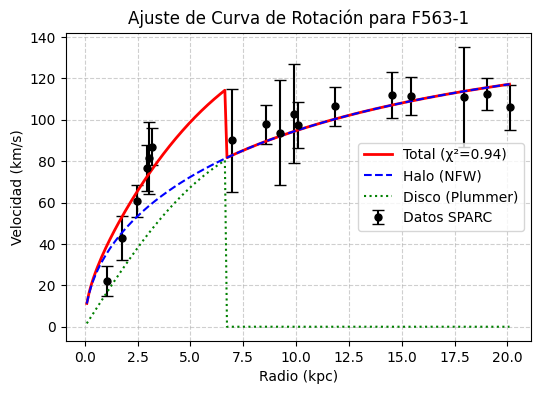


--- Resultados: F563-V2 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 1.713)
  A (Halo)  : 2.84e+11 ± 1.5e+12
  rs (Halo) : 59.38 ± 165.65 kpc
  M (Disco) : 6.94e+10 ± 5.0e+12 M⊙
  b (Disco) : 10.00 ± 250.83 kpc
---------------------------------------------


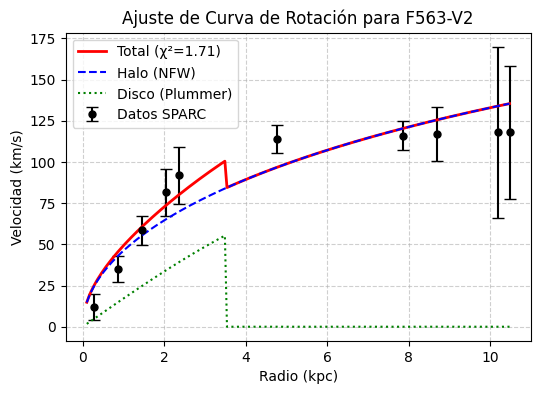


--- Resultados: F568-1 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 0.804)
  A (Halo)  : 4.68e+11 ± 2.2e+12
  rs (Halo) : 76.73 ± 192.80 kpc
  M (Disco) : 3.94e+10 ± 7.5e+11 M⊙
  b (Disco) : 10.00 ± 72.53 kpc
---------------------------------------------


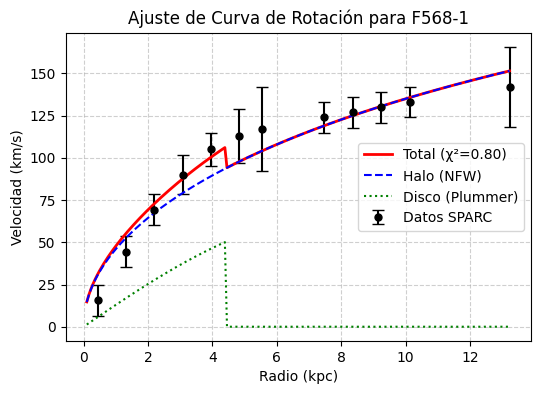


--- Resultados: F568-3 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 4.467)
  A (Halo)  : 1.16e+11 ± 2.5e+11
  rs (Halo) : 55.96 ± 69.80 kpc
  M (Disco) : 3.25e+09 ± 3.4e+10 M⊙
  b (Disco) : 7.93 ± 42.62 kpc
---------------------------------------------


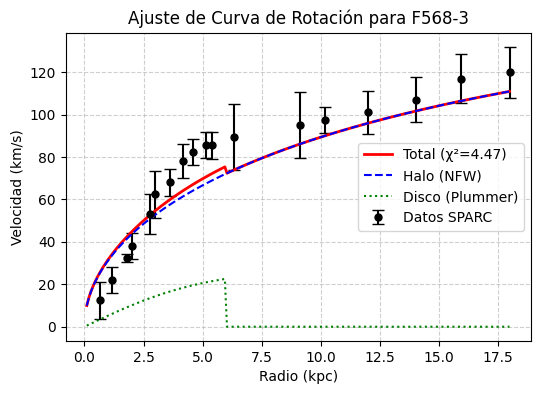


--- Resultados: F568-V1 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 0.088)
  A (Halo)  : 1.31e+10 ± 1.2e+10
  rs (Halo) : 10.51 ± 7.31 kpc
  M (Disco) : 2.42e+10 ± 2.0e+11 M⊙
  b (Disco) : 10.00 ± 38.81 kpc
---------------------------------------------


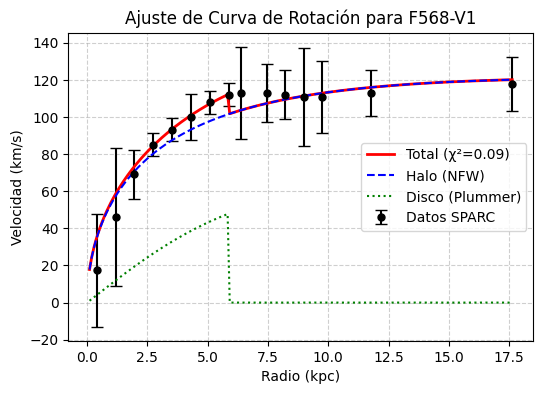


--- Resultados: F571-8 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 1.789)
  A (Halo)  : 9.97e+10 ± 5.2e+10
  rs (Halo) : 32.13 ± 9.95 kpc
  M (Disco) : 2.12e+08 ± 1.7e+11 M⊙
  b (Disco) : 10.00 ± 3320.84 kpc
---------------------------------------------


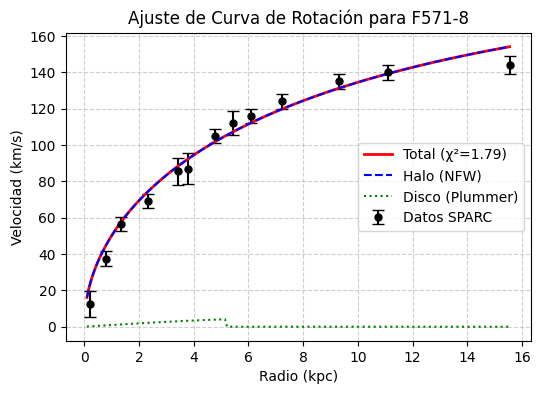


--- Resultados: F574-1 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 1.898)
  A (Halo)  : 1.96e+10 ± 9.4e+09
  rs (Halo) : 17.00 ± 5.31 kpc
  M (Disco) : 7.93e+09 ± 5.0e+11 M⊙
  b (Disco) : 10.00 ± 233.12 kpc
---------------------------------------------


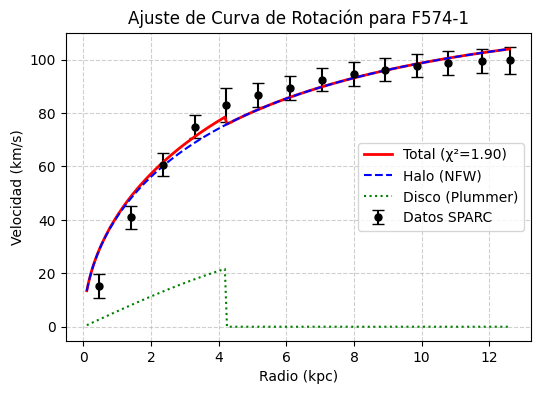


--- Resultados: F579-V1 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 0.121)
  A (Halo)  : 9.22e+09 ± 6.0e+09
  rs (Halo) : 7.96 ± 4.17 kpc
  M (Disco) : 2.28e+09 ± 2.6e+09 M⊙
  b (Disco) : 1.71 ± 1.32 kpc
---------------------------------------------


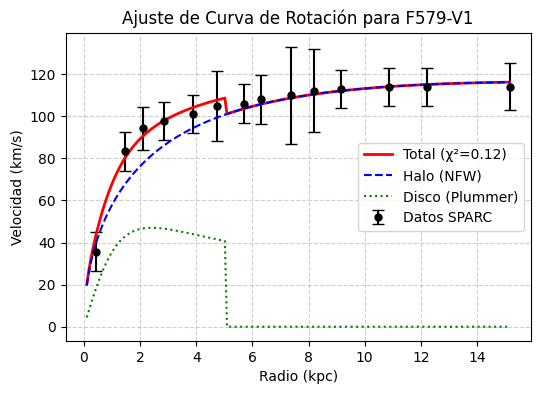


--- Resultados: F583-1 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 1.315)
  A (Halo)  : 9.37e+10 ± 1.4e+11
  rs (Halo) : 56.51 ± 47.96 kpc
  M (Disco) : 3.02e+09 ± 6.8e+09 M⊙
  b (Disco) : 6.30 ± 7.84 kpc
---------------------------------------------


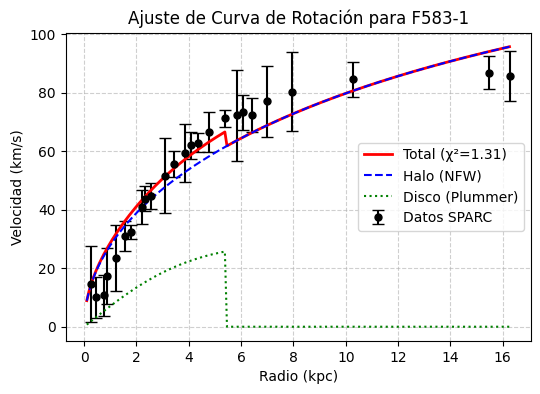


--- Resultados: F583-4 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 0.225)
  A (Halo)  : 3.44e+10 ± 9.6e+10
  rs (Halo) : 32.58 ± 50.51 kpc
  M (Disco) : 1.94e+09 ± 3.0e+10 M⊙
  b (Disco) : 3.73 ± 22.64 kpc
---------------------------------------------


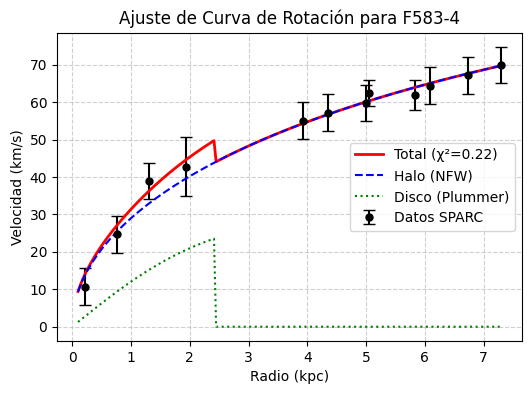


--- Resultados: UGC05750 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 1.494)
  A (Halo)  : 4.28e+11 ± 2.6e+12
  rs (Halo) : 166.43 ± 543.13 kpc
  M (Disco) : 7.41e+09 ± 3.6e+10 M⊙
  b (Disco) : 10.00 ± 22.24 kpc
---------------------------------------------


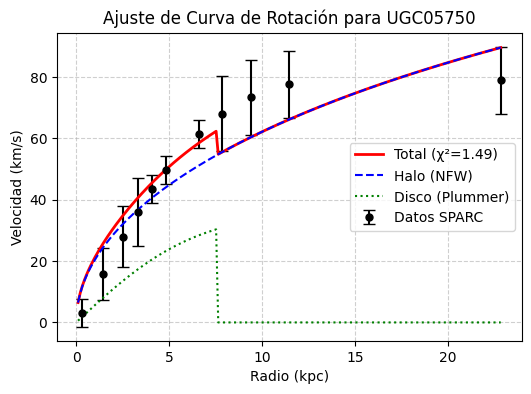


--- Resultados: UGC06614 (NFW + Disco Simp.) ---
Modelo NFW + Disk (χ²_red = 0.159)
  A (Halo)  : 1.65e+11 ± 1.2e+11
  rs (Halo) : 41.61 ± 21.77 kpc
  M (Disco) : 2.17e+10 ± 1.3e+10 M⊙
  b (Disco) : 0.10 ± 19.52 kpc
---------------------------------------------


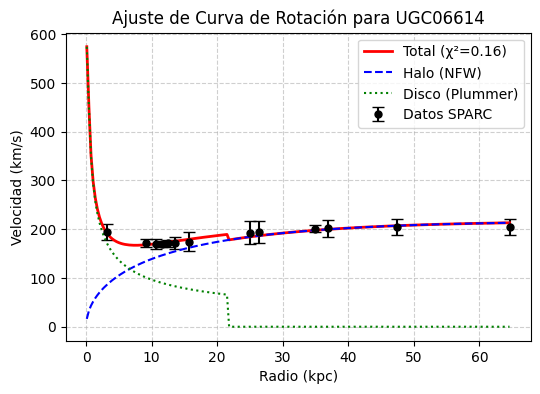

In [10]:
galaxy_files = [
    'data_lsb/F563-1_rotmod.dat',
    'data_lsb/F563-V2_rotmod.dat',
    'data_lsb/F568-1_rotmod.dat',
    'data_lsb/F568-3_rotmod.dat',
    'data_lsb/F568-V1_rotmod.dat',
    'data_lsb/F571-8_rotmod.dat',
    'data_lsb/F574-1_rotmod.dat',
    'data_lsb/F579-V1_rotmod.dat',
    'data_lsb/F583-1_rotmod.dat',
    'data_lsb/F583-4_rotmod.dat',
    'data_lsb/UGC05750_rotmod.dat',
    'data_lsb/UGC06614_rotmod.dat'
]

resultados = {}

for file in galaxy_files:
    galaxy_name = os.path.basename(file).split('_')[0]
    resultados = fit_and_plot_rotation_curve(
        file_path=file,
        show_plot=True,
        save_plot_path=False
        # save_plot_path=f"{galaxy_name}_fit.pdf"
    )

    if resultados:
        resultados[galaxy_name] = resultados